In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import time
import json
from dotenv import load_dotenv

In [2]:
from openai import OpenAI
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [3]:
user_train_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/user_train.json'
user_valid_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/user_valid.json'
user_test_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/user_test.json'

In [4]:
with open(user_train_path, 'rb') as f:
    user_train_dict = json.load(f)
with open(user_valid_path, 'rb') as f:
    user_valid_dict = json.load(f)
with open(user_test_path, 'rb') as f:
    user_test_dict = json.load(f)

In [5]:
user_id = '1'
print(user_train_dict[user_id])
print(user_valid_dict[user_id])
print(user_test_dict[user_id])

[7, 8, 9, 9, 10]
[7, 8, 9, 9, 10, 11]
[8, 9, 9, 10, 11, 12]


In [6]:
item_information_path = '/home/grads/m/mbismay/llm-based-seq-rec/beauty/beauty_data/processed_data/processed_item_information.json'
with open(item_information_path, 'r') as f:
    item_information_dict = json.load(f)
print(len(item_information_dict))

1216


In [7]:
ratings_path = '../../beauty_data/processed_data/ratings.csv'
ratings_df = pd.read_csv(ratings_path)
ratings_df.head()

,item,user,rating,timestamp
0,0,0,4.0,1155081600
1,1,0,5.0,1268697600
2,2,0,5.0,1404604800
3,3,0,5.0,1404604800
4,4,0,5.0,1404604800


In [8]:
def get_item_description(item_information):
    item_details = ""
    if 'title' in item_information:
        item_details += item_information['title']
    if 'brand' in item_information:
        item_details += f" Brand: {item_information['brand']}"
    if 'price' in item_information:
        item_details += f" Price: {item_information['price']}"
    if 'description' in item_information:
        item_details += f" Description: {item_information['description']}"
    return item_details

In [9]:
### Train Data Reaosning
train_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_train_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        try:
            user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        except Exception as e:
            print(f"User: {user} Item: {item} error {e}")
            continue
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    if str(target_item) not in item_information_dict:
        continue
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    train_reasoning_prompts[user] = [prompt, recommendation]
    # break
# print(train_reasoning_prompts)

User: 64 Item: 229 error index 0 is out of bounds for axis 0 with size 0
User: 215 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 274 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 401 Item: 880 error index 0 is out of bounds for axis 0 with size 0
User: 427 Item: 399 error index 0 is out of bounds for axis 0 with size 0


In [10]:
total_len = 0
all_prompt_lens = []
for user, prompt in train_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(train_reasoning_prompts))

383.5144230769231


(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.,   0.,   0.,   3.,   0., 

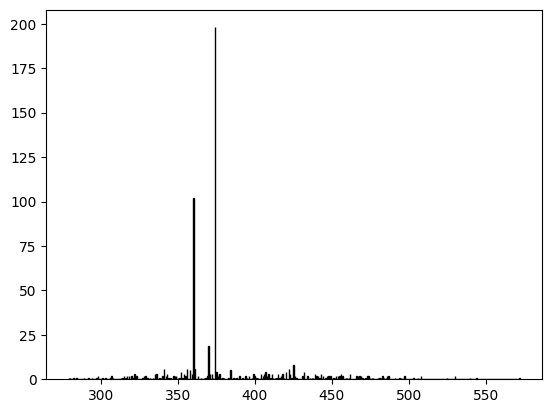

In [11]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [12]:
### Valid Data Reaosning
valid_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_valid_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        try:
            user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        except Exception as e:
            print(f"User: {user} Item: {item} error {e}")
            continue
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    if str(target_item) not in item_information_dict:
        continue
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    valid_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(valid_reasoning_prompts))

User: 64 Item: 229 error index 0 is out of bounds for axis 0 with size 0
User: 215 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 401 Item: 880 error index 0 is out of bounds for axis 0 with size 0
User: 427 Item: 399 error index 0 is out of bounds for axis 0 with size 0
624


In [13]:
total_len = 0
all_prompt_lens = []
for user, prompt in valid_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(valid_reasoning_prompts))

429.2147435897436


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

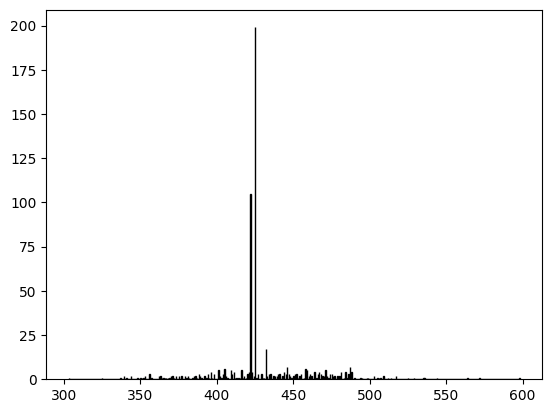

In [14]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [15]:
### Test Data Reaosning
test_reasoning_prompts = dict()
check_missed_items = []
for user, item_list in user_test_dict.items():
    # print(user, item_list)
    user_rating_dict = ratings_df[ratings_df['user'] == int(user)]
    # print(user_rating_dict)
    prompt = "You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\n"
    for item in item_list[:-1]:
        try:
            user_item_rating = user_rating_dict[user_rating_dict['item'] == item]['rating'].values[0]
        except Exception as e:
            print(f"User: {user} Item: {item} error {e}")
            continue
        if user_item_rating > 3:
            ### Liked
            prompt += f"Liked {get_item_description(item_information_dict[str(item)])}\n"
        else:
            prompt += f"Disliked {get_item_description(item_information_dict[str(item)])}\n"
    target_item = item_list[-1]
    if str(target_item) not in item_information_dict:
        continue
    target_item_details = get_item_description(item_information_dict[str(target_item)])
    target_item_rating = user_rating_dict[user_rating_dict['item'] == target_item]['rating'].values[0]
    # print(f"target_item_details: {target_item_details} - {target_item_rating}")

    if target_item_rating > 3:
        prompt += f"""Now, we know that the user will LIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will like the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: Yes"
    else:
        prompt += f"""Now, we know that the user will DISLIKE the next item - {target_item_details}
        As an expert fashion product recommender, do the following steps -
        1. Analyze the provided list of products purchased by the user in order and summarize the user behavior by identifying the characteristics he liked and disliked about the products in at most 100 words.
        2. Explain with reasoning why the user will dislike the next item - {item_information_dict[str(target_item)]['title']} in atmost 100 words."""
        recommendation = "\nPrediction: No"
    # print(f"Prompt: {prompt}")
    test_reasoning_prompts[user] = [prompt, recommendation]
    # break
print(len(test_reasoning_prompts))

User: 64 Item: 229 error index 0 is out of bounds for axis 0 with size 0
User: 215 Item: 399 error index 0 is out of bounds for axis 0 with size 0
User: 401 Item: 880 error index 0 is out of bounds for axis 0 with size 0
User: 427 Item: 399 error index 0 is out of bounds for axis 0 with size 0
622


In [16]:
total_len = 0
all_prompt_lens = []
for user, prompt in test_reasoning_prompts.items():
    all_prompt_lens.append(len(prompt[0].strip().split(' ')))
    total_len += len(prompt[0].strip().split(' '))
print(total_len/len(test_reasoning_prompts))

464.4951768488746


(array([  1.,   1.,   0.,   2.,   7.,   0.,   4.,   4.,   2.,  11.,  10.,
         24.,  26.,  22.,  57.,  52.,  80.,  83.,  74.,  96.,  93., 400.,
         77.,  56.,  34.,  19.,   7.,   6.,   3.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

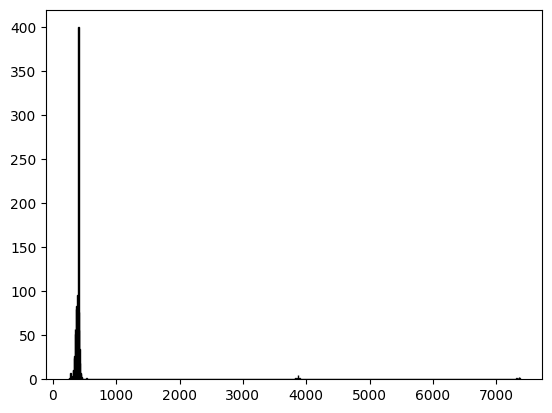

In [43]:
import matplotlib.pyplot as plt

plt.hist(all_prompt_lens, bins=1000, edgecolor='black')

In [19]:
very_long_prompts_users = set()
len_threshold = 600
for user, prompt in test_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)
for user, prompt in train_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)
for user, prompt in valid_reasoning_prompts.items():
    if len(prompt[0].strip().split(' ')) > len_threshold:
        very_long_prompts_users.add(user)

In [20]:
very_long_prompts_users = list(very_long_prompts_users)
print(len(very_long_prompts_users))

1


In [21]:
for user in very_long_prompts_users:
    train_reasoning_prompts.pop(user, None)
    valid_reasoning_prompts.pop(user, None)
    test_reasoning_prompts.pop(user, None)
print(len(train_reasoning_prompts), len(valid_reasoning_prompts), len(test_reasoning_prompts))

623 623 621


In [22]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_train.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(train_reasoning_prompts, f)
    f.close()

In [23]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_valid.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(valid_reasoning_prompts, f)
    f.close()

In [24]:
reasoning_prompt_path = './reasoning_prompt_data/reasoning_prompt_test.pkl'
with open(reasoning_prompt_path, 'wb') as f:
    pickle.dump(test_reasoning_prompts, f)
    f.close()

In [25]:
user = '32'
print(train_reasoning_prompts[user])
print(valid_reasoning_prompts[user])
print(test_reasoning_prompts[user])

["You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -\nLiked Philips Norelco Speed-XL 8240 Men's Shaving System Brand: Philips Norelco Price: $29.35 Description: \n\nProduct: Philips Norelco 8240 Electric Shaver\nStrong Features: Lightweight, well-built, solid feel, close shave, rinsable head\nWeak Features: Lacks countdown timer, may cause irritation without shaving lotion\n\nThe\nLiked Braun Clean &amp; Renew Refill Cartridges CCR - 2 Count (Packaging May Vary) Brand: Braun Price: $11.94 Description: \n\nThe product is a razor clean and renew refill, which works as expected, easy to change, and keeps the razor clean. However, it needs frequent replacement and is costly.\nLiked Williams Lectric Shave, 7 Ounce Brand: Williams Price:  Description: \n\nThe product is a pre-shave that provides a closer shave an

In [26]:
user = '32'
content = train_reasoning_prompts[user][0]
groundtruth = train_reasoning_prompts[user][1]
print(content)
print('*'*100)
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "user",
      "content": content
    }
  ],
  temperature=0,
  max_tokens=256,
  top_p=0.75
)


response = response.choices[0].message.content
print(response)
len(response.split(' '))

You are an expert fashion product recommender. You are provided with a user's list of recent products and their descriptions that the user purchases and whether the user liked it or disliked it. Please go through the list in order -
Liked Philips Norelco Speed-XL 8240 Men's Shaving System Brand: Philips Norelco Price: $29.35 Description: 

Product: Philips Norelco 8240 Electric Shaver
Strong Features: Lightweight, well-built, solid feel, close shave, rinsable head
Weak Features: Lacks countdown timer, may cause irritation without shaving lotion

The
Liked Braun Clean &amp; Renew Refill Cartridges CCR - 2 Count (Packaging May Vary) Brand: Braun Price: $11.94 Description: 

The product is a razor clean and renew refill, which works as expected, easy to change, and keeps the razor clean. However, it needs frequent replacement and is costly.
Liked Williams Lectric Shave, 7 Ounce Brand: Williams Price:  Description: 

The product is a pre-shave that provides a closer shave and a pleasant sm

133